##### `To run this file, make sure the target raw data file (in npy) is under the same folder and change the file name in the second block.`

Last updated on August 2nd, 2022

In [124]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn import metrics
from sklearn.decomposition import PCA

#import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

#for plotting
from matplotlib import pyplot as plt

In [125]:
#read in the data
#dataset.form = [id, speaker, label, some features, opensmile, ngram, embedding]
dataset = np.load("regularOnly.npy", allow_pickle = True)
dataset = np.delete(dataset, 3889, axis=1)
dataset = np.delete(dataset, 3894, axis=1)

#save the data into a csv file under the same directory
df = pd.DataFrame(dataset)
df.to_csv("data.csv")
df[2].value_counts()

1    199
0    154
Name: 2, dtype: int64

In [126]:
def plot_speaker_frequency(nameIndexDic, num=50):
    '''
    parameter:
    nameIndexDic: dict. the dictionary of the appearance count for each speaker
    num: int. indicate the first many speaker data to be drawn in the plot, default 50

    do:
    plot the histogram of each speaker and their record frequency
    '''
    #create x,y list
    name = np.array(list(nameIndexDic.keys()))
    freq = []
    for i in nameIndexDic.values():
        freq.append(len(i))
    freq = np.array(freq)
    index = np.argsort(freq)[::-1]
    name = name[index][:num]
    freq = freq[index][:num]
    fig = plt.figure(figsize = (10, 5))
    # creating the bar plot
    plt.bar(name, freq, color ='maroon',width = 0.4)
    plt.xlabel("speaker name")
    plt.ylabel("frequency")
    plt.xticks(rotation = 90)
    plt.title("Speaker Turn Frequency Plot")

    # Show plot
    plt.show()


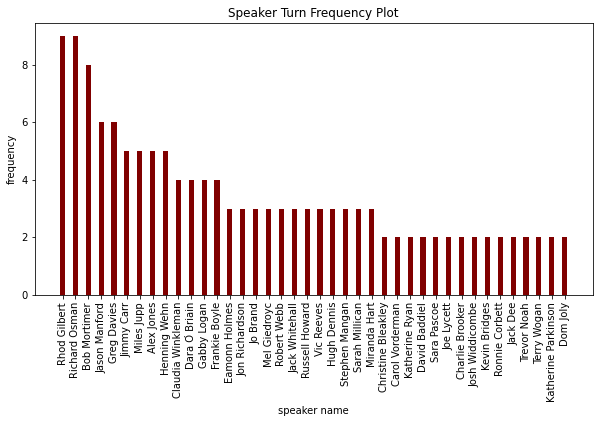

(317,) (36,)


In [127]:
def train_test_split_by_speaker(data, test_size=0.2, pca=False, numPC=50):
    '''
    parameters:
    data: type to be decided, the dataset that we will train the model on
    test_size: the percentage of test data, by default 0.2
    pca: Bool. if to conduct PCA on the dataset, by default False
    numPca: number of principal components, by default 50
    
    return:
    train_x:
    train_y:
    test_x:
    test_y:
    '''

    #initial split of index for train and test 
    # testIndex = list(range(0,numOfVector))
    # trainIndex = list(range(numOfVector,data.shape[0]))
    
    #get the speaker name column
    name = data[:,1]
    nameList = []
    nameIndexDic = {}
    for i in range(name.shape[0]):
        try: 
            nameIndexDic[name[i]].append(i)
        except:
            nameList.append(name[i])
            nameIndexDic[name[i]] = [i]
    nameList = np.array(nameList)
    np.random.shuffle(nameList)

    numOfVector = round(len(nameList)*test_size)
    
    testIndex = []
    trainIndex = []
    #create index list for train and test 
    for j in range(len(nameList)):
        #first test dataset
        if j < numOfVector:
            testIndex = testIndex + nameIndexDic[nameList[j]]
        else: 
            trainIndex = trainIndex + nameIndexDic[nameList[j]]

    data = data[:,2:].astype(float)

    if pca:
        #norm the data
        for i in range(1, data.shape[1]):
            if i == 19:
                data[:,i] = data[:,i]+2
            elif np.std(data[:,i])==0:
                continue
            else:
                data[:,i] = (data[:,i] - np.mean(data[:,i]))/np.std(data[:,i])

        pcaModel = PCA(numPC)
        pcaData = pcaModel.fit_transform(data[:,1:])
        data = np.column_stack((data[:,0],pcaData))

    #split
    test = data[testIndex]
    train = data[trainIndex]
    
    test_x = test[:,1:].astype(float)
    test_y = test[:,0].astype(int)
    train_x = train[:,1:].astype(float)
    train_y = train[:,0].astype(int)

    return train_x, train_y, test_x, test_y, nameIndexDic

#NOTE: the dataset could be distributed not according to the test_size because of multiple repetitions
train_X, train_Y, test_X, test_Y, dic = train_test_split_by_speaker(dataset, pca=True,test_size=0.1)
plot_speaker_frequency(dic, 40)
print(train_Y.shape, test_Y.shape)
# np.savetxt('data.csv', train_X, delimiter=',')

In [128]:
# test if there is empty field
na = np.isnan(train_X)

for i in range(na.shape[0]):
    for j in range(na.shape[1]):
        if bool(na[i,j])==True:
            print(i,j)


In [129]:
def get_statistics(predict_y, real_y, ifNpArr=False):
    '''
    parameters:
    predict_y: npArr. the prediction array
    real_y: npArr. the actual label

    return:
    accuracy: float. 
    precision: float.
    recall: float.

    reference: https://mmuratarat.github.io/2019-10-01/how-to-compute-AUC-plot-ROC-by-hand
    '''
    #lie detection
    #lie is the positive class, truth is negative class
    assert predict_y.shape ==real_y.shape
    tp=0; tn=0; fp=0; fn=0
    for i in range(len(predict_y)):
        #the model predicts it is a lie/positive
        if predict_y[i] == 0:
            if real_y[i] == 0:
                tn += 1
            else:
                fn += 1 
        #the model predicts it is a truth/negative
        else:
            if real_y[i] == 1:
                tp += 1
            else:
                fp += 1

    accuracy = 1-np.count_nonzero(real_y-predict_y)/predict_y.shape[0]
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = fp/(fp+tn)
    f1 = 2*precision*recall/(precision+recall)
    fpr, tpr, thresholds = metrics.roc_curve(real_y, predict_y)
    auc = metrics.auc(fpr, tpr)

    if ifNpArr:
        return np.array([accuracy, precision, recall, specificity, f1, auc])
    else:
        return {"accuracy":"%.3f" % accuracy, "precision":"%.3f" % precision, "recall":"%.3f" % recall, "specificity":"%.3f" % specificity, "f1":"%.3f" % f1, "auc":"%.3f" % auc}

In [130]:
#train on the linear regression
regr = LogisticRegression()
regr.fit(train_X, train_Y)
print(train_Y)
predict_y = regr.predict(test_X)


print("predict",predict_y)
print("actual ", test_Y)
result = get_statistics(predict_y, test_Y)
#auc
print(result)

[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.583', 'precision': '0.615', 'recall': '0.762', 'specificity': '0.667', 'f1': '0.681', 'auc': '0.548'}


In [131]:
rfc = RandomForestClassifier()
rfc.fit(train_X, train_Y)
print(train_Y)
predict_y = rfc.predict(test_X)

print("predict",predict_y)
print("actual ",test_Y)
result = get_statistics(predict_y, test_Y)
print(result)

[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 1 1]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.611', 'precision': '0.640', 'recall': '0.762', 'specificity': '0.600', 'f1': '0.696', 'auc': '0.581'}


In [132]:
dtc = DecisionTreeClassifier()
dtc.fit(train_X, train_Y)
print(train_Y)
predict_y = dtc.predict(test_X)


print("predict",predict_y)
print("actual ",test_Y)
result = get_statistics(predict_y, test_Y)
print(result)

[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.500', 'precision': '0.579', 'recall': '0.524', 'specificity': '0.533', 'f1': '0.550', 'auc': '0.495'}


In [133]:
GNBclf = GaussianNB()
GNBclf.fit(train_X, train_Y)
print(train_Y)
predict_y = GNBclf.predict(test_X)

print("predict",predict_y)
print("actual ",test_Y)
result = get_statistics(predict_y, test_Y)
print(result)

[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [0 1 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.611', 'precision': '0.652', 'recall': '0.714', 'specificity': '0.533', 'f1': '0.682', 'auc': '0.590'}


In [134]:
#only part of the parameters from the paper
DNNmlp = MLPClassifier(hidden_layer_sizes=(1095, 1095, 1095, 1095, 1095, 1095),solver="sgd",learning_rate_init=0.00134)
DNNmlp.fit(train_X, train_Y)
print(train_Y)
predict_y = DNNmlp.predict(test_X)

print("predict",predict_y)
print("actual ",test_Y)
result = get_statistics(predict_y, test_Y)
print(result)

[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [1 1 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.583', 'precision': '0.636', 'recall': '0.667', 'specificity': '0.533', 'f1': '0.651', 'auc': '0.567'}


In [135]:
adb = AdaBoostClassifier()
adb.fit(train_X, train_Y)
print(train_Y)
predict_y = adb.predict(test_X)

print("predict",predict_y)
print("actual ",test_Y)
result = get_statistics(predict_y, test_Y)
print(result)

[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 0 0 1]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.583', 'precision': '0.625', 'recall': '0.714', 'specificity': '0.600', 'f1': '0.667', 'auc': '0.557'}


In [136]:
LSVM = LinearSVC()
LSVM.fit(train_X, train_Y)
print(train_Y)
predict_y = LSVM.predict(test_X)

print("predict",predict_y)
print("actual ",test_Y)
result = get_statistics(predict_y, test_Y)
print(result)


[1 0 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 1 1
 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0
 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 1 1
 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 0 1
 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1]
predict [0 1 1 0 0 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1]
actual  [0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0]
{'accuracy': '0.500', 'precision': '0.579', 'recall': '0.524', 'specificity': '0.533', 'f1': '0.550', 'auc': '0.495'}


/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [137]:
# from sklearn.svm import SVC
# KSVM = SVC(kernel="poly")
# KSVM.fit(train_X, train_Y)
# print(train_Y)
# predict_y = KSVM.predict(test_X)

# print("predict",predict_y)
# print("actual ",test_Y)
# result = get_statistics(predict_y, test_Y)
# print(result)

In [138]:
def run_model_n_times(modelType, n=10, pca=False, numPC=20):
    statistics = np.array([0,0,0,0,0,0])
    #choose the model type
    if modelType == "LR":
        model = LogisticRegression()
    elif modelType == "RF":
        model = RandomForestClassifier()
    elif modelType == "DT":
        model = DecisionTreeClassifier()
    elif modelType == "NB":
        model = GaussianNB()
    elif modelType == "MLP":
        model = MLPClassifier(hidden_layer_sizes=(1095, 1095, 1095, 1095, 1095, 1095),solver="sgd",learning_rate_init=0.00134)
    elif modelType == "Ada":
        model = AdaBoostClassifier()
    elif modelType == "LSVM":
        model = LinearSVC()
    # elif modelType == "KSVM":
    #     model = SVC(kernel="poly")
    
    statistics = []
    for i in range(n):
        #create train and test splits
        train_X, train_Y, test_X, test_Y, _ = train_test_split_by_speaker(dataset, pca = pca, numPC=numPC, test_size=0.1)
        #train
        model.fit(train_X, train_Y)
        predict_y = model.predict(test_X)
        # print(predict_y.shape, test_Y.shape)
        # print("predict",predict_y)
        # print("actual ",test_Y)
        result = get_statistics(predict_y, test_Y, True)
        statistics.append(result)
    
    df = pd.DataFrame(statistics, columns=["accuracy", "precision", "recall", "specificity", "f1", "auc"])
    result = df.quantile([0.25, 0.5, 0.75])
    # std = df.std()*100
    # mean = df.mean()*100
    # upper = mean + std
    # lower = mean - std
    print(result)
    
    #print out the result
    # metricList = ["accuracy", "precision", "recall", "specificity", "f1", "auc"]
    # for i in range(6):
    #     print(metricList[i], "\t", "{:.2f}".format(mean[i]), "{:.2f}".format(lower[i]) + "-" + "{:.2f}".format(upper[i]))

In [139]:
run_model_n_times("LR",pca=False, numPC=10)

/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logisti

      accuracy  precision    recall  specificity        f1       auc
0.25  0.534801   0.585227  0.581938     0.448718  0.556818  0.540969
0.50  0.572297   0.613248  0.671154     0.500000  0.622879  0.573662
0.75  0.648314   0.676667  0.738558     0.551282  0.697917  0.605763


/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
run_model_n_times("RF",pca=False, numPC=10)

      accuracy  precision    recall  specificity        f1       auc
0.25  0.573308   0.550987  0.693144     0.480263  0.616096  0.546332
0.50  0.602823   0.640000  0.738889     0.547917  0.688889  0.585448
0.75  0.636574   0.652174  0.825000     0.632143  0.731203  0.613101


In [141]:
run_model_n_times("DT",pca=False, numPC=10)

      accuracy  precision    recall  specificity        f1       auc
0.25  0.474856   0.506579  0.545151     0.462798  0.545455  0.478571
0.50  0.522727   0.560386  0.600000     0.519231  0.576726  0.520186
0.75  0.575388   0.650000  0.639130     0.625000  0.598936  0.565674


In [142]:
run_model_n_times("NB",pca=False, numPC=10)

      accuracy  precision    recall  specificity        f1       auc
0.25  0.578571   0.632212  0.620536     0.343750  0.635417  0.540975
0.50  0.631944   0.694444  0.645833     0.436842  0.692105  0.629167
0.75  0.661290   0.757740  0.685897     0.584615  0.715545  0.651561


In [143]:
run_model_n_times("MLP",pca=False, numPC=10)

      accuracy  precision    recall  specificity        f1       auc
0.25  0.575630   0.591346  0.651961     0.374081  0.601502  0.556062
0.50  0.620513   0.674242  0.699248     0.468750  0.692105  0.583469
0.75  0.666667   0.719130  0.735324     0.587010  0.738248  0.660885


In [144]:
run_model_n_times("Ada",pca=False, numPC=10)

      accuracy  precision    recall  specificity        f1       auc
0.25  0.584052   0.612440  0.613462     0.441761  0.632212  0.582384
0.50  0.608422   0.642713  0.732143     0.514706  0.661202  0.596039
0.75  0.655556   0.666667  0.799451     0.540865  0.707143  0.651489


In [145]:
run_model_n_times("LSVM",pca=False, numPC=10)

/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinea

      accuracy  precision    recall  specificity        f1       auc
0.25  0.556650   0.533422  0.517857     0.428571  0.525000  0.553571
0.50  0.582751   0.615079  0.615079     0.447222  0.615079  0.574532
0.75  0.605044   0.628472  0.681364     0.476667  0.653428  0.608757


/Users/yuki/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
